<a href="https://colab.research.google.com/github/Jeffateth/AllergenPredict/blob/main/AlgPred_CNN_XGBoost_1280dim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas requests
from google.colab import drive
import os

# Mount Drive. (Authorize when prompted.)
drive.mount('/content/drive')

# Set the folder where you'll save your outputs.
drive_path = "/content/drive/MyDrive/AllergenAI new/CNN"


print(f"All generated files will be saved to: {drive_path}")


Mounted at /content/drive
All generated files will be saved to: /content/drive/MyDrive/AllergenAI new/CNN


In [ ]:
import pandas as pd
import requests
import os

# -------------------------------
# Mount Google Drive
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')

# Set the folder path on your Drive (adjust as needed)
drive_path = "/content/drive/MyDrive/AllergenAI new/CNN"
os.makedirs(drive_path, exist_ok=True)
print("Output folder:", drive_path)

# -------------------------------
# URLs and Fasta Parser
# -------------------------------
datasets = {
    "train_positive": ("https://webs.iiitd.edu.in/raghava/algpred2/datasets/train_positive.txt", 1),
    "train_negative": ("https://webs.iiitd.edu.in/raghava/algpred2/datasets/train_negative.txt", 0),
    "test_positive": ("https://webs.iiitd.edu.in/raghava/algpred2/datasets/validation_positive.txt", 1),
    "test_negative": ("https://webs.iiitd.edu.in/raghava/algpred2/datasets/validation_negative.txt", 0)
}

def parse_fasta(text, label):
    entries, cur_id, cur_seq = [], None, ""
    for line in text.strip().splitlines():
        line = line.strip()
        if line.startswith(">"):
            if cur_id:
                entries.append((cur_id, cur_seq, label))
            cur_id = line[1:]
            cur_seq = ""
        else:
            cur_seq += line
    if cur_id and cur_seq:
        entries.append((cur_id, cur_seq, label))
    return entries

# -------------------------------
# Process and Save Each Dataset
# -------------------------------
for setname in ["train", "test"]:
    entries = []
    for k, (url, label) in datasets.items():
        if k.startswith(setname):
            print(f"⬇️ Downloading {k}")
            r = requests.get(url)
            entries.extend(parse_fasta(r.text, label))
    df = pd.DataFrame(entries, columns=["id", "sequence", "label"])

    # Save to Google Drive folder using os.path.join to form a full path
    out_csv = os.path.join(drive_path, f"algpred2_{setname}.csv")
    df.to_csv(out_csv, index=False)

    print(f"✅ Saved {setname} set: {len(df)} entries")
    print("Saved files in:", drive_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Output folder: /content/drive/MyDrive/AllergenAI_new
⬇️ Downloading train_positive
⬇️ Downloading train_negative
✅ Saved train set: 16120 entries
Saved files in: /content/drive/MyDrive/AllergenAI_new
⬇️ Downloading test_positive
⬇️ Downloading test_negative
✅ Saved test set: 4030 entries
Saved files in: /content/drive/MyDrive/AllergenAI_new


In [ ]:
!pip install fair-esm torch pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import pandas as pd
import torch
import esm
from tqdm import tqdm
import os
import csv

#for dataset in ["algpred2_train.csv", "algpred2_test.csv"]:
for dataset in ["algpred2_test.csv"]:
    # Determine base name
    base = os.path.splitext(os.path.basename(dataset))[0]

    # Load dataset
    df = pd.read_csv(dataset)
    sequences = list(df["sequence"])
    labels = list(df["label"])
    ids = list(df["id"])

    # Load ESM-2 model
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval()

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Output files (unique per dataset)
    temp_file = f"{base}_esm2_embeddings_temp.csv"
    final_file = f"{base}_esm2_embeddings.csv"

    # Already processed IDs (for resuming)
    if os.path.exists(temp_file):
        processed_ids = set(pd.read_csv(temp_file, usecols=["id"])["id"])
        print(f"🔁 Resuming from {temp_file} — {len(processed_ids)} entries already processed.")
    else:
        processed_ids = set()

    # Filter data
    remaining_data = [(ids[i], sequences[i], labels[i]) for i in range(len(ids)) if ids[i] not in processed_ids]

    # Batch setup
    batch_size = 1
    write_header = not os.path.exists(temp_file)
    feature_dim = 1280
    fieldnames = ["id", "label"] + [f"f{k}" for k in range(feature_dim)]

    print(f"⚙️  Extracting embeddings using ESM-2 for {dataset}... ({len(remaining_data)} sequences remaining)")

    with open(temp_file, mode="a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if write_header:
            writer.writeheader()

        for i in tqdm(range(0, len(remaining_data), batch_size)):
            batch = remaining_data[i:i + batch_size]
            batch_ids = [x[0] for x in batch]
            batch_seqs = [x[1] for x in batch]
            batch_labels = [x[2] for x in batch]

            batch_data = [(batch_ids[j], batch_seqs[j]) for j in range(len(batch_seqs))]
            _, _, batch_tokens = batch_converter(batch_data)
            batch_tokens = batch_tokens.to(device)

            with torch.no_grad():
                outputs = model(batch_tokens, repr_layers=[33])  # Layer 33 for T33
                token_representations = outputs["representations"][33]

            rows = []
            for j, (_, seq) in enumerate(batch_data):
                representation = token_representations[j, 1:len(seq)+1].mean(0)
                entry = {
                    "id": batch_ids[j],
                    "label": batch_labels[j],
                }
                for k in range(feature_dim):
                    entry[f"f{k}"] = representation[k].item()
                rows.append(entry)

            writer.writerows(rows)

    # Final save
    os.replace(temp_file, final_file)

    print(f"✅ Final embeddings saved to '{final_file}'\n")


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


⚙️  Extracting embeddings using ESM-2 for algpred2_test.csv... (4030 sequences remaining)


100%|██████████| 4030/4030 [05:14<00:00, 12.81it/s]

✅ Final embeddings saved to 'algpred2_test_esm2_embeddings.csv'



In [ ]:
import pandas as pd

df = pd.read_csv("algpred2_train.csv")
print(df.head())
print(df.shape)  # Rows, features

     id                                           sequence  label
0  P_13  MGKPFTLSLSSLCLLLLSSACFAISSSKLNECQLNNLNALEPDHRV...      1
1  P_14  MGVFTFEDEINSPVAPATLYKALVTDADNVIPKALDSFKSVENVEG...      1
2  P_17  MAEDEDNQQGQGEGLKYLGFVQDAATYAVTTFSNVYLFAKDKSGPL...      1
3  P_46  MGVFNYEVETPSVISAARLFKSYVLDGDKLIPKVAPQAITSVENVG...      1
4  P_47  MGVFNYEVETPSVIPAARLFKSYVLDGDKLIPKVAPQAITSVENVE...      1
(16120, 3)


# CNN


In [ ]:
!pip install keras-tuner --upgrade --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
# ===============================
# Step 0: Imports
# ===============================
import os
import random
import pandas as pd
import numpy as np
import gc

# Sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.dummy import DummyClassifier

# TensorFlow / Keras
import tensorflow as tf
import keras_tuner as kt

# XGBoost (for Y-Scrambling)
import xgboost as xgb

# Output redirection
import sys
from contextlib import redirect_stdout


# ===============================
# Step 1: Mount Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/AllergenAI-new/CNN"
os.makedirs(drive_path, exist_ok=True)
print(f"All generated files will be saved to: {drive_path}")


# ===============================
# Step 2: Load and Prepare Data
# ===============================
df_train = pd.read_csv("/content/drive/MyDrive/AllergenAI-new/CNN/algpred2_train_esm2_1280dim_embeddings.csv")
df_test = pd.read_csv("/content/drive/MyDrive/AllergenAI-new/CNN/algpred2_test_esm2_1280dim_embeddings.csv")


feature_cols = [f"f{i}" for i in range(1280)]
X_train = df_train[feature_cols].values
y_train = df_train["label"].values
X_test = df_test[feature_cols].values
y_test = df_test["label"].values

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
X_temp, y_temp = X_train, y_train


# ====================================
# Step 3: Dummy Classifier Baseline
# ====================================
print("\n📉 DummyClassifier (Stratified) on Train+Val:\n")
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy_aucs = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in cv.split(X_temp, y_temp):
    dummy.fit(X_temp[train_idx], y_temp[train_idx])
    y_dummy_proba = dummy.predict_proba(X_temp[val_idx])[:, 1]
    auc = roc_auc_score(y_temp[val_idx], y_dummy_proba)
    dummy_aucs.append(auc)
print(f"📊 Dummy ROC-AUC: {np.mean(dummy_aucs):.4f} ± {np.std(dummy_aucs):.4f}")


# ===============================
# Step 4: Reshape for CNN
# ===============================
X_train = X_train.reshape(-1, 1280, 1)
X_test = X_test.reshape(-1, 1280, 1)


# ===============================
# Step 5: Define Hypermodel
# ===============================
def build_cnn_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(1280, 1)))
    model.add(tf.keras.layers.Conv1D(
        filters=hp.Choice('filters', values=[16, 32, 64]),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu'
    ))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('lr', 1e-4, 1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


# ===============================
# Step 6: Hyperparameter Tuning
# ===============================
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, test_size=0.2, train_size=0.1, stratify=y_train, random_state=42
)

tuner = kt.Hyperband(
    build_cnn_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='cnn_tuning_cpu',
    project_name='AllergenPredict_CNN_CPU'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        tf.keras.backend.clear_session()
        gc.collect()

print("\n🚀 Starting hyperparameter tuning...")
tuner.search(
    X_train_part, y_train_part,
    epochs=5,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[stop_early, ClearMemoryCallback()]
)
gc.collect()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters found:")
print(f" - Filters: {best_hps.get('filters')}")
print(f" - Kernel Size: {best_hps.get('kernel_size')}")
print(f" - Dropout Rate: {best_hps.get('dropout')}")
print(f" - Dense Units: {best_hps.get('dense_units')}")
print(f" - Learning Rate: {best_hps.get('lr')}")


# ===============================
# Step 7: Final Model Training
# ===============================
print("\nTraining final model...")
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=8,
    callbacks=[stop_early]
)


# ===============================
# Step 8: Evaluate on Test Set
# ===============================
y_test_proba = model.predict(X_test).ravel()
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_test_proba)
report = classification_report(y_test, y_test_pred, digits=4)

print("\nFinal Evaluation on Test Set:")
print(f"Final Test ROC-AUC: {test_auc:.4f}")
print("Classification Report:")
print(report)


# ===============================
# Step 9: Y-Scrambling Control
# ===============================
y_scrambled = y_train.copy()
random.seed(42)
random.shuffle(y_scrambled)

scrambled_aucs = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in cv.split(X_train, y_scrambled):
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_scrambled[train_idx], y_scrambled[val_idx]

    model_scrambled = tf.keras.Sequential([
        tf.keras.Input(shape=(1280, 1)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model_scrambled.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model_scrambled.fit(X_fold_train, y_fold_train, epochs=5, verbose=0)
    y_proba_scrambled = model_scrambled.predict(X_fold_val).ravel()
    auc = roc_auc_score(y_fold_val, y_proba_scrambled)
    scrambled_aucs.append(auc)

print(f"Y-Scrambled AUC: {np.mean(scrambled_aucs):.4f} ± {np.std(scrambled_aucs):.4f}")


# ===============================
# Step 10: Save Log to Drive
# ===============================
log_filepath = os.path.join(drive_path, "evaluation_log_cpu.txt")
with open(log_filepath, "w") as f_out, redirect_stdout(f_out):
    print("Final Evaluation on Test Set:")
    print(f"Final Test ROC-AUC: {test_auc:.4f}")
    print("Classification Report:")
    print(report)

print(f"\n✅ Logs saved to: {log_filepath}")


Trial 30 Complete [00h 00m 23s]
val_accuracy: 0.628722071647644

Best val_accuracy So Far: 0.7099875807762146
Total elapsed time: 00h 05m 15s

Best hyperparameters found:
 - Filters: 16
 - Kernel Size: 5
 - Dropout Rate: 0.2
 - Dense Units: 64
 - Learning Rate: 0.0036569295366168696

Training final model...
Epoch 1/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6260 - loss: 0.6636 - val_accuracy: 0.1678 - val_loss: 1.1206
Epoch 2/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6730 - loss: 0.6019 - val_accuracy: 0.7602 - val_loss: 0.5504
Epoch 3/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7044 - loss: 0.5477 - val_accuracy: 0.4907 - val_loss: 0.7543
Epoch 4/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7267 - loss: 0.5307 - val_accuracy: 0.8189 - val_loss: 0.5329
Epoch 5/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7268 - loss: 0.5217 - val_accuracy: 0.8524 - val_loss: 0.4700
Epoch 6/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━

# MLP - Multi-Layer Perceptron

In [ ]:
# ===============================
# Step 4: Use flat features (no reshape)
# ===============================
# No need to reshape: X_train and X_test already have shape (n_samples, 1280)


# ===============================
# Step 5: Define the MLP Model
# ===============================
def build_mlp_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(1280,)))

    # 1 to 3 hidden layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f"units_{i}", min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(tf.keras.layers.Dropout(
            rate=hp.Float(f"dropout_{i}", min_value=0.2, max_value=0.5, step=0.1)
        ))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("lr", 1e-4, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


# ===============================
# Step 6: Hyperparameter Tuning
# ===============================
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, test_size=0.2, train_size=0.1, stratify=y_train, random_state=42
)

tuner = kt.Hyperband(
    build_mlp_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='mlp_tuning',
    project_name='AllergenPredict_MLP'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        tf.keras.backend.clear_session()
        gc.collect()

print("\n🚀 Starting MLP hyperparameter tuning...")
tuner.search(
    X_train_part, y_train_part,
    epochs=5,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[stop_early, ClearMemoryCallback()]
)
gc.collect()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters found for MLP:")
print(f" - Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"   - Layer {i+1}: {best_hps.get(f'units_{i}')} units, dropout {best_hps.get(f'dropout_{i}')}")
print(f" - Learning Rate: {best_hps.get('lr')}")


# ===============================
# Step 7: Final Model Training
# ===============================
print("\nTraining final MLP model...")
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=8,
    callbacks=[stop_early]
)


# ===============================
# Step 8: Evaluate on Test Set
# ===============================
y_test_proba = model.predict(X_test).ravel()
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_test_proba)
report = classification_report(y_test, y_test_pred, digits=4)

print("\nFinal Evaluation on Test Set (MLP):")
print(f"Final Test ROC-AUC: {test_auc:.4f}")
print("Classification Report:")
print(report)


Trial 30 Complete [00h 00m 22s]
val_accuracy: 0.9640198349952698

Best val_accuracy So Far: 0.9652605652809143
Total elapsed time: 00h 04m 53s

Best hyperparameters found for MLP:
 - Layers: 2
   - Layer 1: 192 units, dropout 0.2
   - Layer 2: 64 units, dropout 0.2
 - Learning Rate: 0.0004231890726974646

Training final MLP model...
Epoch 1/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9173 - loss: 0.2089 - val_accuracy: 0.9274 - val_loss: 0.2200
Epoch 2/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9664 - loss: 0.0997 - val_accuracy: 0.9625 - val_loss: 0.1232
Epoch 3/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9751 - loss: 0.0785 - val_accuracy: 0.9774 - val_loss: 0.0701
Epoch 4/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9794 - loss: 0.0653 - val_accuracy: 0.9380 - val_loss: 0.1816
Epoch 5/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9855 - loss: 0.0492 - val_accuracy: 0.9730 - val_loss: 0.0933
Epoch 6/20
1612

In [ ]:
# ✅ Install dependencies
!pip install -q tensorflow scikeras

# ==============================
# ✅ Imports and Setup
# ==============================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt

# ==============================
# ✅ Load ESM-2 Embedding Data
# ==============================
from google.colab import drive
drive.mount('/content/drive')
train_csv = "/content/drive/MyDrive/AllergenAI-new/CNN/algpred2_train_esm2_1280dim_embeddings.csv"
df = pd.read_csv(train_csv)

feature_cols = [f"f{i}" for i in range(1280)]
X = df[feature_cols].values
y = df["label"].values

# ==============================
# ✅ Define the MLP model (TF/Keras)
# ==============================
def create_mlp_model():
    model = Sequential()
    model.add(Dense(192, activation='relu', input_shape=(1280,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

mlp_clf = KerasClassifier(model=create_mlp_model, epochs=10, batch_size=32, verbose=0)

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp_clf)
])

xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

# ==============================
# ✅ Nested Cross-Validation (5-fold)
# ==============================
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_accuracies = []
outer_aucs = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"\n🚀 Fold {fold}/5")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train models
    mlp_pipeline.fit(X_train, y_train)
    xgb_clf.fit(X_train, y_train)

    # --- MLP ---
    X_test_scaled = mlp_pipeline.named_steps['scaler'].transform(X_test)
    y_proba_mlp = mlp_pipeline.named_steps['mlp'].predict_proba(X_test_scaled)[:, 1]
    y_pred_mlp = (y_proba_mlp >= 0.5).astype(int)
    acc_mlp = accuracy_score(y_test, y_pred_mlp)
    auc_mlp = roc_auc_score(y_test, y_proba_mlp)

    # --- XGBoost ---
    y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
    y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)
    acc_xgb = accuracy_score(y_test, y_pred_xgb)
    auc_xgb = roc_auc_score(y_test, y_proba_xgb)

    # --- Ensemble (Soft Voting) ---
    y_proba_ens = 0.5 * y_proba_mlp + 0.5 * y_proba_xgb
    y_pred_ens = (y_proba_ens >= 0.5).astype(int)
    acc_ens = accuracy_score(y_test, y_pred_ens)
    auc_ens = roc_auc_score(y_test, y_proba_ens)

    print(f"📊 MLP       → Accuracy: {acc_mlp:.4f}, ROC-AUC: {auc_mlp:.4f}")
    print(f"📊 XGBoost   → Accuracy: {acc_xgb:.4f}, ROC-AUC: {auc_xgb:.4f}")
    print(f"🤝 Ensemble  → Accuracy: {acc_ens:.4f}, ROC-AUC: {auc_ens:.4f}")

    outer_accuracies.append(acc_ens)
    outer_aucs.append(auc_ens)


# ==============================
# ✅ Report Results
# ==============================
acc_mean = np.mean(outer_accuracies)
acc_se = np.std(outer_accuracies, ddof=1) / np.sqrt(len(outer_accuracies))

auc_mean = np.mean(outer_aucs)
auc_se = np.std(outer_aucs, ddof=1) / np.sqrt(len(outer_aucs))

print("\n🧠 Final Evaluation Summary:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_se:.4f} (SE)")
print(f"ROC-AUC:  {auc_mean:.4f} ± {auc_se:.4f} (SE)")

# Show per-fold results
results_df = pd.DataFrame({
    "Fold": list(range(1, 6)),
    "Accuracy": outer_accuracies,
    "ROC-AUC": outer_aucs
})
display(results_df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🚀 Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✔️ Accuracy: 0.9854 | ROC-AUC: 0.9971

🚀 Fold 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✔️ Accuracy: 0.9864 | ROC-AUC: 0.9982

🚀 Fold 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✔️ Accuracy: 0.9867 | ROC-AUC: 0.9986

🚀 Fold 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✔️ Accuracy: 0.9873 | ROC-AUC: 0.9982

🚀 Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✔️ Accuracy: 0.9851 | ROC-AUC: 0.9984

🧠 Final Evaluation Summary:
Accuracy: 0.9862 ± 0.0004 (SE)
ROC-AUC:  0.9981 ± 0.0003 (SE)


,Fold,Accuracy,ROC-AUC
0,1,0.985422,0.997072
1,2,0.986352,0.998206
2,3,0.986663,0.998590
3,4,0.987283,0.998154
4,5,0.985112,0.998356


In [ ]:
# ==============================
# ✅ Load test set
# ==============================
test_csv = "/content/drive/MyDrive/AllergenAI-new/CNN/algpred2_test_esm2_1280dim_embeddings.csv"
df_test = pd.read_csv(test_csv)
X_test_final = df_test[feature_cols].values
y_test_final = df_test["label"].values

# ==============================
# ✅ Train on full training data (no CV)
# ==============================
mlp_pipeline.fit(X, y)
xgb_clf.fit(X, y)

# ==============================
# ✅ Predict on test set (manual soft voting)
# ==============================
# Scale using fitted scaler from pipeline
X_test_scaled = mlp_pipeline.named_steps['scaler'].transform(X_test_final)
y_proba_mlp = mlp_pipeline.named_steps['mlp'].predict_proba(X_test_scaled)[:, 1]
y_proba_xgb = xgb_clf.predict_proba(X_test_final)[:, 1]

# Soft voting
y_proba_test = 0.5 * y_proba_mlp + 0.5 * y_proba_xgb
y_pred_test = (y_proba_test >= 0.5).astype(int)

# ==============================
# ✅ Evaluation
# ==============================
from sklearn.metrics import classification_report

test_acc = accuracy_score(y_test_final, y_pred_test)
test_auc = roc_auc_score(y_test_final, y_proba_test)

print("\n🧪 Final Evaluation on Test Set (Soft-Voting Ensemble):")
print(f"Accuracy: {test_acc:.4f}")
print(f"ROC-AUC:  {test_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test_final, y_pred_test, digits=4))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🧪 Final Evaluation on Test Set (Soft-Voting Ensemble):
Accuracy: 0.8744
ROC-AUC:  0.9802
Classification Report:
              precision    recall  f1-score   support

           0     0.8041    0.9901    0.8875      2015
           1     0.9871    0.7588    0.8580      2015

    accuracy                         0.8744      4030
   macro avg     0.8956    0.8744    0.8727      4030
weighted avg     0.8956    0.8744    0.8727      4030



In [ ]:
# ✅ Install dependencies
!pip install -q xgboost pandas scikit-learn matplotlib numpy

# ==============================
# ✅ Imports and Setup
# ==============================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import os

# ==============================
# ✅ Mount Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/AllergenAI-new/XGBoost"
os.makedirs(drive_path, exist_ok=True)
print(f"All generated files will be saved to: {drive_path}")

# ==============================
# ✅ Load ESM-2 Embedding Data
# ==============================
train_csv = "/content/drive/MyDrive/AllergenAI-new/CNN/algpred2_train_esm2_1280dim_embeddings.csv"
test_csv = "/content/drive/MyDrive/AllergenAI-new/CNN/algpred2_test_esm2_1280dim_embeddings.csv"

df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)

feature_cols = [f"f{i}" for i in range(1280)]
X_train = df_train[feature_cols].values
y_train = df_train["label"].values
X_test = df_test[feature_cols].values
y_test = df_test["label"].values

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# ==============================
# ✅ Hyperparameter Tuning for XGBoost
# ==============================
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Create a smaller subset for hyperparameter tuning
X_tune, _, y_tune, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42, stratify=y_train)

# Initialize XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
print("\n🔍 Starting hyperparameter tuning for XGBoost...")
random_search.fit(X_tune, y_tune)

# Get the best parameters
best_params = random_search.best_params_
print("\n✅ Best hyperparameters found:")
for param, value in best_params.items():
    print(f"- {param}: {value}")

# Create the best XGBoost model with tuned hyperparameters
xgb_best = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    **best_params
)



Mounted at /content/drive
All generated files will be saved to: /content/drive/MyDrive/AllergenAI-new/XGBoost
Train size: (16120, 1280), Test size: (4030, 1280)

🔍 Starting hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:27:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Best hyperparameters found:
- subsample: 1.0
- n_estimators: 100
- min_child_weight: 1
- max_depth: 6
- learning_rate: 0.2
- gamma: 0.1
- colsample_bytree: 0.9

🔄 Performing 5-fold cross-validation...

🚀 Fold 1/5


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [2]:
# ==============================
# ✅ Nested Cross-Validation (5-fold)
# ==============================
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

print("\n🔄 Performing 5-fold cross-validation...")

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_accuracies = []
outer_aucs = []

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
    print(f"\n🚀 Fold {fold}/5")

    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgboost', xgb_best)            # your tuned XGBClassifier instance
    ])

    # Train with early stopping on the validation fold
    pipeline.fit(
        X_fold_train,
        y_fold_train,
        xgboost__eval_set=[(X_fold_val, y_fold_val)],
        xgboost__verbose=False
    )

    # Predict & score
    y_proba = pipeline.predict_proba(X_fold_val)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y_fold_val, y_pred)
    auc = roc_auc_score(y_fold_val, y_proba)
    print(f"📊 XGBoost → Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")

    outer_accuracies.append(acc)
    outer_aucs.append(auc)

# ==============================
# ✅ Report Cross-Validation Results
# ==============================
import numpy as np
import pandas as pd

acc_mean, acc_std = np.mean(outer_accuracies), np.std(outer_accuracies, ddof=1)
acc_se = acc_std / np.sqrt(len(outer_accuracies))
auc_mean, auc_std = np.mean(outer_aucs), np.std(outer_aucs, ddof=1)
auc_se = auc_std / np.sqrt(len(outer_aucs))

print("\n🧠 Cross-Validation Summary:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_se:.4f} (SE)")
print(f"ROC-AUC:  {auc_mean:.4f} ± {auc_se:.4f} (SE)\n")

# Per-fold table
results_df = pd.DataFrame({
    "Fold":      list(range(1, 6)),
    "Accuracy":  outer_accuracies,
    "ROC-AUC":   outer_aucs
})
print(results_df)


# ==============================
# ✅ Y-Scrambling Control
# ==============================
import random

print("\n🔀 Performing Y-Scrambling control test...")

# Copy and shuffle labels
y_scrambled = y_train.copy()
random.seed(42)
np.random.shuffle(y_scrambled)

scrambled_aucs = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in cv.split(X_train, y_scrambled):
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_scrambled[train_idx], y_scrambled[val_idx]

    # Simpler model for scrambling test
    xgb_scramble = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    xgb_scramble.fit(X_fold_train, y_fold_train)
    y_proba_scrambled = xgb_scramble.predict_proba(X_fold_val)[:, 1]
    auc = roc_auc_score(y_fold_val, y_proba_scrambled)
    scrambled_aucs.append(auc)

print(f"Y-Scrambled AUC: {np.mean(scrambled_aucs):.4f} ± {np.std(scrambled_aucs):.4f}")

# ==============================
# ✅ Train on full training data and evaluate on test set
# ==============================
print("\n🧪 Training final model on full training data...")

# Create and fit the final pipeline
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', xgb_best)
])

# Get validation data for early stopping
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

final_pipeline.fit(
    X_train_fit,
    y_train_fit,
    xgboost__eval_set=[(X_val, y_val)],
    xgboost__verbose=0
)

# ==============================
# ✅ Predict on test set
# ==============================
y_test_proba = final_pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

# ==============================
# ✅ Final Evaluation
# ==============================
test_acc = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
test_report = classification_report(y_test, y_test_pred, digits=4)

print("\n🏁 Final Evaluation on Test Set:")
print(f"Accuracy: {test_acc:.4f}")
print(f"ROC-AUC:  {test_auc:.4f}")
print("Classification Report:")
print(test_report)

# ==============================
# ✅ Feature Importance Analysis
# ==============================
# Get feature importances
feature_importances = final_pipeline.named_steps['xgboost'].feature_importances_

# Create DataFrame with feature importances
importance_df = pd.DataFrame({
    'Feature': [f'f{i}' for i in range(1280)],
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(np.arange(len(top_features)), top_features['Importance'], align='center')
plt.yticks(np.arange(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()

# Save the plot
importance_plot_path = os.path.join(drive_path, "xgboost_feature_importance.png")
plt.savefig(importance_plot_path)
plt.show()

print(f"\n✅ Feature importance plot saved to: {importance_plot_path}")

# ==============================
# ✅ Save the model and results
# ==============================
import pickle

# Save the trained pipeline
model_path = os.path.join(drive_path, "allergen_xgboost_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(final_pipeline, f)

# Save the results
results = {
    'cv_accuracy': acc_mean,
    'cv_accuracy_se': acc_se,
    'cv_auc': auc_mean,
    'cv_auc_se': auc_se,
    'test_accuracy': test_acc,
    'test_auc': test_auc,
    'best_params': best_params,
    'y_scrambled_auc': np.mean(scrambled_aucs)
}

results_path = os.path.join(drive_path, "allergen_xgboost_results.pkl")
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

# Save predictions on test set
test_predictions = pd.DataFrame({
    'id': df_test['id'],
    'true_label': y_test,
    'predicted_label': y_test_pred,
    'probability': y_test_proba
})

predictions_path = os.path.join(drive_path, "allergen_xgboost_test_predictions.csv")
test_predictions.to_csv(predictions_path, index=False)

print(f"\n✅ Model saved to: {model_path}")
print(f"✅ Results saved to: {results_path}")
print(f"✅ Test predictions saved to: {predictions_path}")

# ==============================
# ✅ Performance Visualization
# ==============================
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save ROC curve
roc_path = os.path.join(drive_path, "allergen_xgboost_roc_curve.png")
plt.savefig(roc_path)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Save PR curve
pr_path = os.path.join(drive_path, "allergen_xgboost_pr_curve.png")
plt.savefig(pr_path)
plt.show()

print(f"\n✅ ROC curve saved to: {roc_path}")
print(f"✅ Precision-Recall curve saved to: {pr_path}")
print("\n🎉 XGBoost analysis completed successfully!")


🔄 Performing 5-fold cross-validation...


NameError: name 'X_train' is not defined


🔍 Tuning XGBoost hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:55:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔄 Performing 5-fold cross-validation...

🚀 Fold 1/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:55:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9864, ROC-AUC: 0.9974

🚀 Fold 2/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9848, ROC-AUC: 0.9977

🚀 Fold 3/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9873, ROC-AUC: 0.9990

🚀 Fold 4/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9854, ROC-AUC: 0.9981

🚀 Fold 5/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9870, ROC-AUC: 0.9988

🧠 CV Summary → Accuracy: 0.9862 ± 0.0005, ROC-AUC: 0.9982 ± 0.0003

🔀 Performing Y-scrambling control test...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Y-Scrambled AUC: 0.4970 ± 0.0064

🧪 Training final model on full training data...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:01:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Final model saved to: /content/drive/MyDrive/AllergenAI-new/XGBoost/XGBoost_ESM-2_1280dim_algpred2_xgboost_model.pkl

🏁 Evaluating on test set...
Test Accuracy: 0.8809
Test ROC-AUC: 0.9806
Classification Report:
               precision    recall  f1-score   support

           0     0.8131    0.9891    0.8925      2015
           1     0.9861    0.7727    0.8664      2015

    accuracy                         0.8809      4030
   macro avg     0.8996    0.8809    0.8795      4030
weighted avg     0.8996    0.8809    0.8795      4030


🧮 Feature Importance (Top 20)
✅ Feature importance plot saved to: /content/drive/MyDrive/AllergenAI-new/XGBoost/xgboost_feat_importance_top20.png
✅ ROC curve saved to: /content/drive/MyDrive/AllergenAI-new/XGBoost/xgboost_roc_curve.png
✅ Precision-Recall curve saved to: /content/drive/MyDrive/AllergenAI-new/XGBoost/xgboost_pr_curve.png

🎉 XGBoost analysis completed successfully!


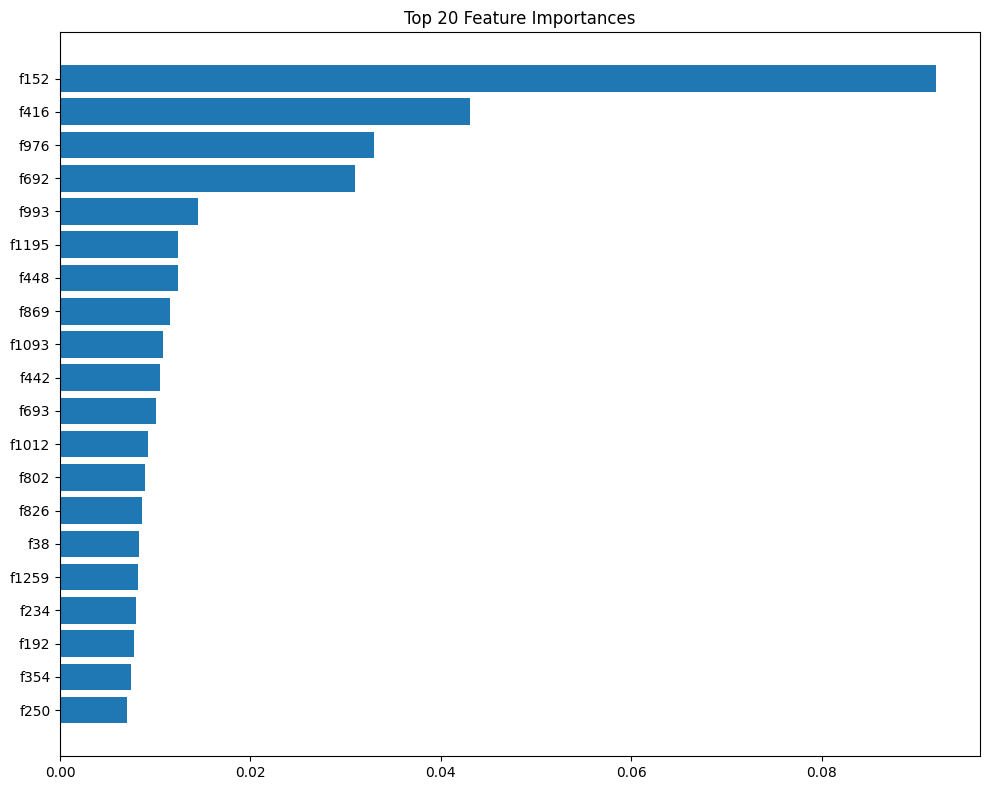

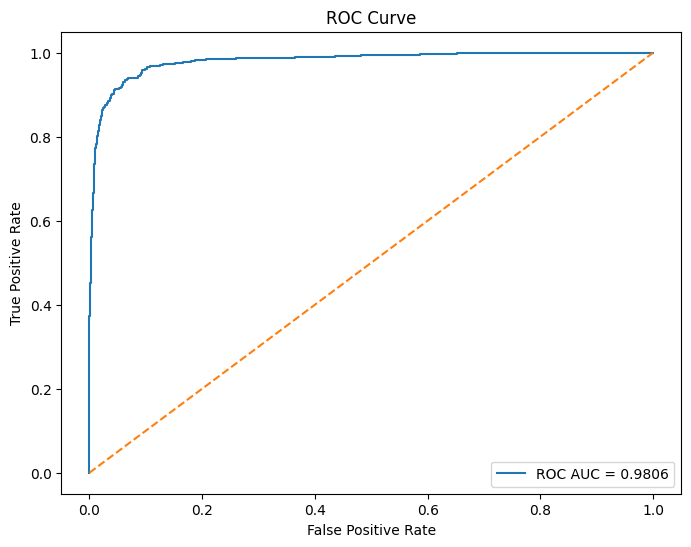

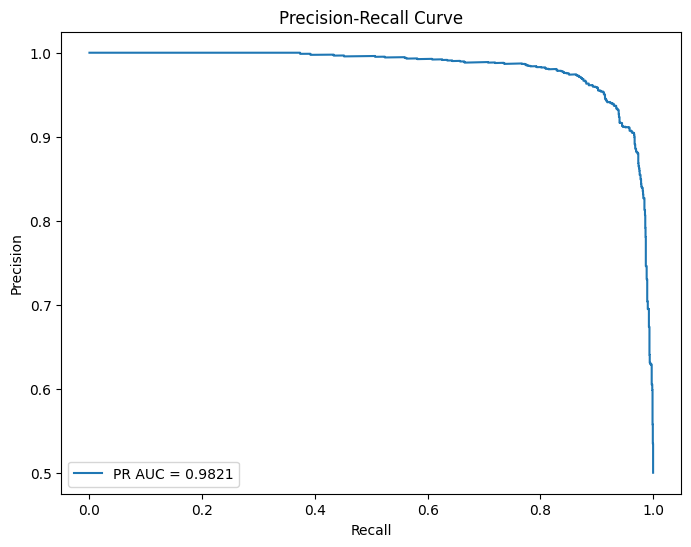

In [3]:
# ==========================================
# ✅ Allergenicity Prediction - Final Script
# ✅ Using ESM-2 1280-dim + XGBoost + SHAP
# ✅ With early saving before test evaluation
# ==========================================

import os
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    roc_curve, precision_recall_curve, auc
)

# === Paths Configuration ===
drive_path = "/content/drive/MyDrive/AllergenAI-new/XGBoost"
os.makedirs(drive_path, exist_ok=True)
train_csv = "/content/drive/MyDrive/AllergenAI-new/CNN/algpred2_train_esm2_1280dim_embeddings.csv"
test_csv  = "/content/drive/MyDrive/AllergenAI-new/CNN/algpred2_test_esm2_1280dim_embeddings.csv"

# === Load ESM-2 Embeddings Data ===
df_train = pd.read_csv(train_csv)
df_test  = pd.read_csv(test_csv)
feature_cols = [f"f{i}" for i in range(1280)]
X_train = df_train[feature_cols].values
y_train = df_train["label"].values
X_test  = df_test[feature_cols].values
y_test  = df_test["label"].values

# === Hyperparameter Tuning ===
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}
# Subsample for tuning
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
)
xgb = XGBClassifier(
    objective='binary:logistic', use_label_encoder=False,
    eval_metric='logloss', random_state=42
)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
print("\n🔍 Tuning XGBoost hyperparameters...")
random_search.fit(X_tune, y_tune)
best_params = random_search.best_params_

# Best model
xgb_best = XGBClassifier(
    objective='binary:logistic', use_label_encoder=False,
    eval_metric='logloss', random_state=42,
    **best_params
)

# === 5-Fold Cross-Validation ===
print("\n🔄 Performing 5-fold cross-validation...")
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_accuracies, outer_aucs = [], []
for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
    print(f"\n🚀 Fold {fold}/5")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgboost', xgb_best)
    ])
    pipeline.fit(
        X_train[train_idx], y_train[train_idx],
        xgboost__eval_set=[(X_train[val_idx], y_train[val_idx])],
        xgboost__verbose=False
    )
    y_proba = pipeline.predict_proba(X_train[val_idx])[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    acc = accuracy_score(y_train[val_idx], y_pred)
    auc_score = roc_auc_score(y_train[val_idx], y_proba)
    print(f"Accuracy: {acc:.4f}, ROC-AUC: {auc_score:.4f}")
    outer_accuracies.append(acc)
    outer_aucs.append(auc_score)

# Summary CV
acc_mean, acc_se = np.mean(outer_accuracies), np.std(outer_accuracies, ddof=1)/np.sqrt(len(outer_accuracies))
auc_mean, auc_se = np.mean(outer_aucs), np.std(outer_aucs, ddof=1)/np.sqrt(len(outer_aucs))
print(f"\n🧠 CV Summary → Accuracy: {acc_mean:.4f} ± {acc_se:.4f}, ROC-AUC: {auc_mean:.4f} ± {auc_se:.4f}")

# === Y-Scrambling Control ===
print("\n🔀 Performing Y-scrambling control test...")
np.random.seed(42)
y_scrambled = np.random.permutation(y_train)
scrambled_aucs = []
for train_idx, val_idx in outer_cv.split(X_train, y_scrambled):
    xgb_scramble = XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3,
        objective='binary:logistic', use_label_encoder=False,
        eval_metric='logloss', random_state=42
    )
    xgb_scramble.fit(
        X_train[train_idx], y_scrambled[train_idx]
    )
    y_scr_proba = xgb_scramble.predict_proba(X_train[val_idx])[:, 1]
    scrambled_aucs.append(roc_auc_score(y_scrambled[val_idx], y_scr_proba))
print(f"Y-Scrambled AUC: {np.mean(scrambled_aucs):.4f} ± {np.std(scrambled_aucs):.4f}")

# === Final Training & Early Save ===
print("\n🧪 Training final model on full training data...")
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', xgb_best)
])
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)
final_pipeline.fit(
    X_train_fit, y_train_fit,
    xgboost__eval_set=[(X_val, y_val)],
    xgboost__verbose=False
)
# Save model before test evaluation
dumped_model_path = os.path.join(drive_path, "XGBoost_ESM-2_1280dim_algpred2_xgboost_model.pkl")
joblib.dump(final_pipeline, dumped_model_path)
print(f"✅ Final model saved to: {dumped_model_path}")

# === Test Set Evaluation ===
print("\n🏁 Evaluating on test set...")
y_test_proba = final_pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred, digits=4))

# === Feature Importance Analysis ===
print("\n🧮 Feature Importance (Top 20)")
importances = final_pipeline.named_steps['xgboost'].feature_importances_
feat_imp_df = pd.DataFrame({ 'Feature': feature_cols, 'Importance': importances }).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,8))
plt.barh(feat_imp_df['Feature'].head(20), feat_imp_df['Importance'].head(20))
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances')
plt.tight_layout()
feature_plot_path = os.path.join(drive_path, 'xgboost_feat_importance_top20.png')
plt.savefig(feature_plot_path)
print(f"✅ Feature importance plot saved to: {feature_plot_path}")

# === Performance Curves ===
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_path = os.path.join(drive_path, 'xgboost_roc_curve.png')
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_test_proba):.4f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig(roc_path)
print(f"✅ ROC curve saved to: {roc_path}")

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_path = os.path.join(drive_path, 'xgboost_pr_curve.png')
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR AUC = {auc(recall, precision):.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig(pr_path)
print(f"✅ Precision-Recall curve saved to: {pr_path}")

print("\n🎉 XGBoost analysis completed successfully!")
